In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load CMS exclusion curve

In [2]:
cmsData = pd.read_pickle('../AuxInfo/CMS-EXO-20-004-data/ADD_Monojet_DF.pcl')
cmsCurve = np.genfromtxt('../AuxInfo/CMS-EXO-20-004-data/HEPData-ins1894408-v2-csv/ADDM_{D}limits.csv',
                        skip_header=20,names=True,delimiter=',',skip_footer=28)
print(cmsCurve.dtype.names)
# print(cmsCurve)

('d', 'Lower_limit_on_M_D_TeV')


### Load Recast Data

In [3]:
recastData = pd.read_pickle('../scanResults_ADD.pcl')
recastData['$M_{D}$'] = recastData['$M_{D}$']/1000.0 # Change to TeV

### Get all model points

In [4]:
models = []
mCols = ['Coupling','Mode','$M_{D}$','$d$']
for row in recastData[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
print('%i models loaded' %len(models))

150 models loaded


### Get model parameters

In [5]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$M_{D}$','$d$']])
print(textstr)

{'Coupling': 'ADD', 'Mode': 'DM+QCDjets', '$M_{D}$': [3.5, 3.0, 5.0, 4.0, 4.5, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 13.0, 14.0, 15.0, 12.5, 13.5, 14.5], '$d$': [2, 3, 4, 5, 6, 7]}
Coupling = ADD
Mode = DM+QCDjets


In [6]:
# Remove duplicated data from other datasets
recastData = recastData[recastData['Data-takingperiod'] == 2017]
cmsData = cmsData[cmsData['Data-takingperiod'] == 2017]

In [7]:
kfactor = 0.8
lmuData = np.log10(recastData['$\mu^{UL}_{obs}$']/kfactor)

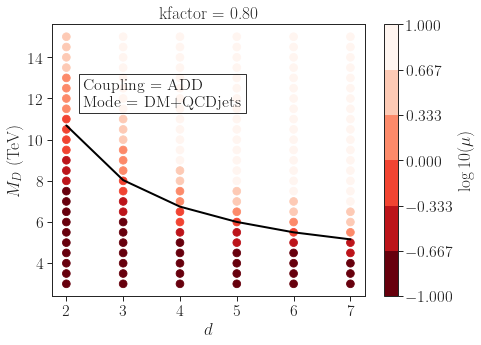

In [8]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=recastData['$d$'],y=recastData['$M_{D}$'],vmin=-1.0,vmax=1.0,
            c=lmuData,cmap=plt.cm.get_cmap('Reds_r', 6),s=60)
cbar = plt.colorbar(label=r'$\log10(\mu)$')
cbar.set_ticks([-1.0,-0.6666,-0.3333,0.0,0.33333,0.66666,1.0])
plt.plot(cmsCurve['d'],cmsCurve['Lower_limit_on_M_D_TeV'],label='CMS',linewidth=2,color='black')
plt.xlabel(r'$d$')
plt.ylabel(r'$M_{D}$ (TeV)')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
plt.title('kfactor = %1.2f' %kfactor)
plt.text(0.1,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.show()

### Interpolate for a denser grid

In [9]:
pts = np.array([x for x in product(range(2,8,1),np.linspace(5.0,15.,100))])
lmuPts = griddata(list(zip(recastData['$d$'],recastData['$M_{D}$'])),
                  lmuData,pts)
pts = pts[~np.isnan(lmuPts)]
lmuPts = lmuPts[~np.isnan(lmuPts)]

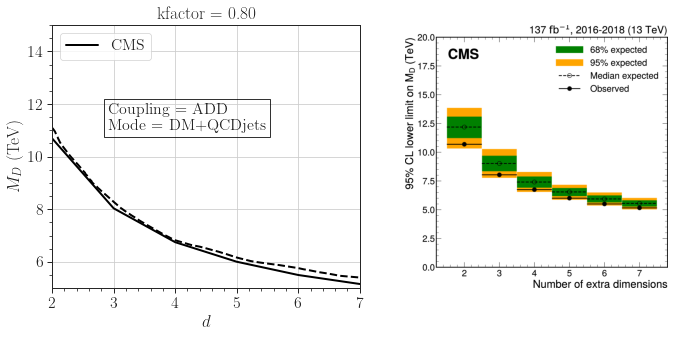

In [15]:
fig,ax = plt.subplots(figsize=(10,5),ncols=2,nrows=1)


# p = ax[0].scatter(x=pts[:,0],y=pts[:,1],vmin=-1.0,vmax=1.0,
#             c=lmuPts,cmap=plt.cm.get_cmap('Reds_r', 6))
# cbar = plt.colorbar(p,label=r'$\log10(\mu)$',ax=ax[0])
# cbar.set_ticks([-1.0,-0.6666,-0.3333,0.0,0.33333,0.66666,1.0])
cs = ax[0].tricontour(pts[:,0],pts[:,1],lmuPts,levels=[0.0],
               linewidths=2,linestyles='dashed',colors='black')


# cs.collections[0].set_label('Recast')



ax[0].plot(cmsCurve['d'],cmsCurve['Lower_limit_on_M_D_TeV'],label='CMS',linewidth=2,color='black')
ax[0].legend(loc='upper left')
ax[0].set_xlabel(r'$d$')
ax[0].set_ylabel(r'$M_{D}$ (TeV)')
# ax[0].set_ylim(-10,1500)
# ax[0].set_xlim(0,3000)
ax[0].minorticks_on()
ax[0].text(0.18,0.6,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = ax[0].transAxes)
ax[0].set_title('kfactor = %1.2f' %kfactor)
ax[0].grid()

cmsPlot = plt.imread('../AuxInfo/CMS-EXO-20-004-data/CMS-EXO-20-004_Figure_011.png')
ax[1].imshow(cmsPlot)
ax[1].axis('off')
plt.tight_layout()
plt.savefig('cms_exo_20_004_add.png')
plt.show()